# Weather Data Collection for PJM inter connected Grid

In this Jupyter notebook weather data is collected for use in a project designed to find relationships between power and weather
Most weather websites used data collected at local airports to record and forcast weather for the regionin order to reduce the number of datapoints location data for airports has been downloaded from datahub
the airport locations will be culled for those regions who are in the PJM service area
the API being used limits historical calls to 31 day intervals and returns hourly data. in order to collect data for a full year data will need to be called multiple times. 


In [472]:

#import necessary libraries 
import time 
import datetime
from dateutil.rrule import rrule, DAILY, MONTHLY
from datetime import  timedelta
import json, csv
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import timeit
from decimal import Decimal

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:,.6f}'.format


In [473]:
#import the airport-codes_csv.csv
# https://datahub.io/core/airport-codes#resource-airport-codes
Airport_codes_df = pd.read_csv('/Users/robertshiles/CSV_files/airport-codes_csv.csv',encoding= 'latin1')
Airport_codes_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.000000,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,"3,435.000000",NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.000000,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.000000,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.000000,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [474]:
# Ohio   
# DC
# West Virgina
# Virginia
# Pennsylvania
# Deleware
# New JErsy
# Marryland
# Eastern Kentucky 
# Eastern indiana
# south western michigan 
# Northcentral/eastern Illiniose
# north eastern north carolina 

In [491]:
# cull the airport codes to include only large and medium sized airports in the PJM interconection grid 


#remove closed ,heliport, seaplane_base, and possibly small_airport 

included_types=['large_airport','medium_airport']

PJM_states=['US-PA','US-DC','US-MD', 'US-NJ',
           'US-OH', 'US-VA', 'US-DE',
           'US-WV','US-IL','US-IN',
           'US-MI', 'US-NC', 'US-KY']
#select major and medium sized airports in the states covered by PJM 
pjm_Airport_codes = Airport_codes_df.loc[Airport_codes_df['iso_region'].isin(PJM_states)]
pjm_Airport_codes = pjm_Airport_codes.loc[pjm_Airport_codes['type'].isin(included_types)]


#convert the airport coordinated string into two seperate floating numbers for latitude and longituded
pjm_Airport_codes['coordinates'] = pjm_Airport_codes['coordinates'].str.split(',')
pjm_Airport_codes['lon'], pjm_Airport_codes['lat'] = zip(*pjm_Airport_codes.coordinates)

#pjm_Airport_codes['lat'] = f'{pjm_Airport_codes['lat']:.2f}'
#pjm_Airport_codes['lon'] = f'{pjm_Airport_codes['lon']:.2f}'

pjm_Airport_codes['lat'] = pjm_Airport_codes['lat'].astype(float)
pjm_Airport_codes['lon'] = pjm_Airport_codes['lon'].astype(float)


#pjm_Airport_codes['lat'] = pjm_Airport_codes['lat'].apply(lambda x: Decimalx.quantize(Decimal('0.000000')))
#pjm_Airport_codes['lon'] = pjm_Airport_codes['lon'].apply(lambda x: x.quantize(Decimal('0.000000')))

pjm_Airport_codes['lat'] = pjm_Airport_codes['lat'].apply(lambda x: "{:.6f}".format(x))
pjm_Airport_codes['lon'] = pjm_Airport_codes['lon'].apply(lambda x: "{:.6f}".format(x))

#drop rows with empty coordinates 
pjm_Airport_codes = pjm_Airport_codes.dropna(subset=['lat', 'lon','coordinates'])

#reset the index of the new dataframe 
pjm_Airport_codes = pjm_Airport_codes.reset_index(drop=True)

#"{:.2f}".format('lat')
#pjm_Airport_codes['lat'] = pjm_Airport_codes['lat'].round(6)
#pjm_Airport_codes['lon'] = pjm_Airport_codes['lon'].round(6)

#pjm_Airport_codes['cost'].map('{:,.2f}'.format) style.format("{:.2%}")



In [492]:
pjm_Airport_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 14 columns):
ident           163 non-null object
type            163 non-null object
name            163 non-null object
elevation_ft    163 non-null float64
continent       0 non-null object
iso_country     163 non-null object
iso_region      163 non-null object
municipality    163 non-null object
gps_code        163 non-null object
iata_code       158 non-null object
local_code      163 non-null object
coordinates     163 non-null object
lon             163 non-null object
lat             163 non-null object
dtypes: float64(1), object(13)
memory usage: 18.0+ KB


In [494]:
indecies = []
for ind in pjm_Airport_codes.index:
    indecies.append(ind)
print(indecies)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162]


In [495]:
start = timeit.timeit()

airport_test_url=[]
working = []
num_working = 0
num_broken = 0


for ind in pjm_Airport_codes.index:
    responce  = requests.get('https://api.weather.com/v1/geocode/{}/{}/observations/historical.json?apiKey=6532d6454b8aa370768e63d6ba5a832e&startDate=20181231&endDate=20181231&units=e'.format(pjm_Airport_codes['lat'].iloc[ind],pjm_Airport_codes['lon'].iloc[ind]))
    api = responce.json()
        
    try:
        reading_df = pd.DataFrame(api["observations"])
        #working_airports.append((lat_airport[k],lon_airport[k])) 
        num_working +=1
        working.append(True)
        print('{}number working{}'.format(ind,num_working))
    except KeyError:
        num_broken=+1
        working.append(False)
        print('{}number broken{}'.format(ind,num_broken))
        #if api["errors"]["message"]==('Invalid lat/long specification'):
            #print("bad location{}{}".format(lat_airport[k],lon_airport[k]))
            
        #else:
            
    time.sleep(.1)  

pjm_Airport_codes['working'] = working                           
print("number working{} number broken{}".format(num_working,num_broken))     

#print the elapsed time 
end = timeit.timeit()
print("time:",end - start)
                                  
       

0number working1
1number working2
2number working3
3number working4
4number working5
5number working6
6number working7
7number working8
8number working9
9number working10
10number working11
11number working12
12number working13
13number working14
14number working15
15number working16
16number working17
17number working18
18number working19
19number working20
20number working21
21number broken1
22number working22
23number working23
24number working24
25number working25
26number working26
27number working27
28number working28
29number working29
30number working30
31number working31
32number working32
33number working33
34number working34
35number working35
36number working36
37number working37
38number working38
39number working39
40number working40
41number working41
42number working42
43number working43
44number working44
45number working45
46number working46
47number working47
48number working48
49number working49
50number working50
51number working51
52number working52
53number worki

In [496]:
pjm_Airport_codes.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lon,lat,working
0,KABE,medium_airport,Lehigh Valley International Airport,393.000000,NaN,US,US-PA,Allentown,KABE,ABE,ABE,"[-75.44080352783203, 40.652099609375]",-75.440804,40.652100,True
1,KACY,medium_airport,Atlantic City International Airport,75.000000,NaN,US,US-NJ,Atlantic City,KACY,ACY,ACY,"[-74.57720184326172, 39.45759963989258]",-74.577202,39.457600,True
2,KADW,large_airport,Joint Base Andrews,280.000000,NaN,US,US-MD,Camp Springs,KADW,ADW,ADW,"[-76.866997, 38.810799]",-76.866997,38.810799,True
3,KAGC,medium_airport,Allegheny County Airport,"1,252.000000",NaN,US,US-PA,Pittsburgh,KAGC,AGC,AGC,"[-79.9301986694336, 40.354400634765625]",-79.930199,40.354401,True
4,KAKR,medium_airport,Akron Fulton International Airport,"1,067.000000",NaN,US,US-OH,Akron,KAKR,AKC,AKR,"[-81.4669036865, 41.0374984741]",-81.466904,41.037498,True


/Users/robertshiles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/Users/robertshiles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/robertshiles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


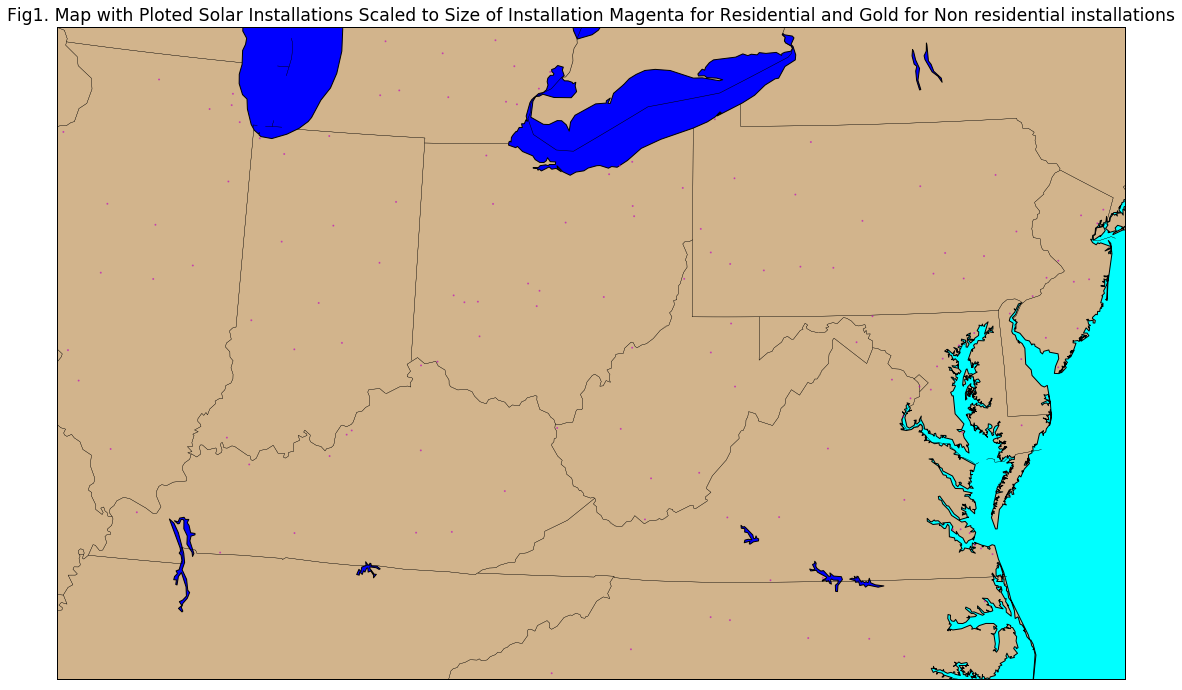

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [504]:
#llcr=35.254916, -89.781679
#urcr=48.572002, -60.451053
42.680216, -73.470890
#mid=39.156135, -94.742782

#Get county, state, solar pannel area, latitude and longitude data from Deep Solar Dataset
#energytype = Deep_Solar_df.loc[:,['county', 'state','lat', 'lon','total_panel_area',"total_panel_area_nonresidential","total_panel_area_residential"]]

#Determine figure size 
plt.figure(figsize=(24,12))

#create map lcc projection of united states 
map = Basemap(llcrnrlon=-89.7,llcrnrlat=35.,urcrnrlon=-73.5,urcrnrlat=43,resolution='i',projection='tmerc',lon_0=-80,lat_0=39)
#fill in colors draw boundries for countries and states 
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='tan',lake_color='blue')
map.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
map.drawstates(linewidth=0.25, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
map.drawcoastlines()

#map.drawparallels(np.arange(10,70,20),labels=[1,1,0,0])
#map.drawmeridians(np.arange(-100,0,20),labels=[0,0,0,1])
plt.title('Fig1. Map with Ploted Solar Installations Scaled to Size of Installation Magenta for Residential and Gold for Non residential installations', fontsize='xx-large')




lons = pjm_Airport_codes['lon'].to_numpy()
lats = pjm_Airport_codes['lat'].to_numpy()
#typ = pjm_Airport_codes['type'].to_numpy()

typ  = pjm_Airport_codes['type'] = pjm_Airport_codes['type'].apply(lambda x: 3 if x== 'large_airport'else(2 if x=='medium_airport'else 1)).to_numpy()

'large_airport','medium_airport','small_airport'
#x, y = map(lons, lats)
x, y = map(lons, lats)

colours = ['w','r','g','b']
#c = colours[typ.to_numpy()]

# plot points to map and scale to pannel area and color for residential and non
plt.scatter(x, y,s=typ**3,color='m', alpha=.5, zorder=9)

#plt.scatter(x, y,s=(energytype['total_panel_area_residential']/1000),color='m', alpha=.5, zorder=10)


plt.show()

print (typ)


In [509]:
pjm_Airport_codes.loc[pjm_Airport_codes['gps_code']=='KMDT']

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lon,lat,working
100,KMDT,1,Harrisburg International Airport,310.000000,NaN,US,US-PA,Harrisburg,KMDT,MDT,MDT,"[-76.7633972168, 40.1935005188]",-76.763397,40.193501,True


In [544]:
# create a list of airport coordinates

US_State = str('Pennsylvania')

US_State_dict={'Pennsylvania':'US-PA','Washington_DC':'US-DC','Maryland':'US-MD', 'New_Jersey':'US-NJ',
           'Ohio':'US-OH','Virginia':'US-VA', 'Deleware':'US-DE',
           'West_Virginia':'US-WV','Illinios':'US-IL','Indiana':'US-IN',
           'Michigan':'US-MI','North_Carolina':'US-NC','Kentucky':'US-KY'}


pjm_Airport_codes['lat']
subset = pjm_Airport_codes[['lat', 'lon', 'gps_code']].loc[Airport_codes_df['iso_region']==US_State_dict[US_State]]
coordinates_airport = [list(x) for x in subset.to_numpy()]
print(len(coordinates_airport))

print(US_State,US_State_dict[US_State] )

7
Pennsylvania US-PA


In [545]:
#create a list of URLS to call the API with 


from datetime import datetime
from dateutil.rrule import rrule, DAILY, MONTHLY
from datetime import  timedelta

now = datetime.now() # current date and time

coordinates_airport

#test geocode 
#lat_airport = [40.188468]
#lon_airport = [-76.775258]

#YMD
#enter  the start and end date you would like to call from the API 
#startingDate = datetime(2014, 1, 1)
#EndingDate = datetime(2018,12,31)

#short version for code testing 
startingDate = datetime(2014, 1, 1)
EndingDate = datetime(2018,12,30)



#create a list of dates between the start and end date with month long increments 
startdates = (list(rrule(MONTHLY, dtstart=startingDate, until=EndingDate)))
enddates = []
#create a list of dates offset by (-)one day to mark the end of the month
for i, date in enumerate (startdates):
    enddates.append(startdates[i]- timedelta(days=1))

#enddates   = startdates - timedelta(days=1)


startdates =  [date.__str__() for date in startdates]
startdates = [date.replace('-','') for date in startdates]
startdates = [date.replace(' 00:00:00','') for date in startdates]

enddates =  [date.__str__() for date in enddates]
enddates = [date.replace('-','') for date in enddates]
enddates = [date.replace(' 00:00:00','') for date in enddates]

#create an empty list to store the URL dates in 
url_dates = []
# for each date insert the start and end date into the URL 

for j in range(len(coordinates_airport)):
        for i in range(len(startdates)-1):
            url_dates.append('https://api.weather.com/v1/geocode/{}/{}/observations/historical.json?apiKey=6532d6454b8aa370768e63d6ba5a832e&startDate={}&endDate={}&units=e'.format(coordinates_airport[j][0],coordinates_airport[j][1],startdates[i],enddates[i+1]))
    
    
#print(url_dates)
# the length of the URL dates should be approximatly be 12*num_years*num_airports
print(len(url_dates))


413


In [546]:
print(len(url_dates))

413


In [539]:
responce  = requests.get(url_dates[0])
api = responce.json()
try:
    reading_df = pd.DataFrame(api["observations"])
    weather_df = weather_df.append(reading_df,ignore_index = True)
except KeyError:
    print(str(api))
    print(n,url_dates[n])
    for key in api.keys(): print(key)
        
print(api["observations"])

[{'key': 'KABE', 'class': 'observation', 'expire_time_gmt': 1388559060, 'obs_id': 'KABE', 'obs_name': 'Allentown', 'valid_time_gmt': 1388551860, 'day_ind': 'N', 'temp': 23, 'wx_icon': 27, 'icon_extd': 2700, 'wx_phrase': 'Mostly Cloudy', 'pressure_tend': None, 'pressure_desc': None, 'dewPt': 8, 'heat_index': 23, 'rh': 53, 'pressure': 29.89, 'vis': 10, 'wc': 17, 'wdir': None, 'wdir_cardinal': 'VAR', 'gust': None, 'wspd': 5, 'max_temp': None, 'min_temp': 17, 'precip_total': None, 'precip_hrly': None, 'snow_hrly': None, 'uv_desc': 'Low', 'feels_like': 17, 'uv_index': 0, 'qualifier': None, 'qualifier_svrty': None, 'blunt_phrase': None, 'terse_phrase': None, 'clds': 'BKN', 'water_temp': None, 'primary_wave_period': None, 'primary_wave_height': None, 'primary_swell_period': None, 'primary_swell_height': None, 'primary_swell_direction': None, 'secondary_swell_period': None, 'secondary_swell_height': None, 'secondary_swell_direction': None}, {'key': 'KABE', 'class': 'observation', 'expire_time_

In [548]:
weather_df = pd.DataFrame()


#with open('weather_data.json')as file:
for n in range(len(url_dates)):
        responce  = requests.get(url_dates[n])
        api = responce.json()
        try:
            reading_df = pd.DataFrame(api["observations"])
            weather_df = weather_df.append(reading_df,ignore_index = True)

        except KeyError:
            print(str(api))
            print(n,url_dates[n])
            for key in api.keys(): print(key)
        
        print(n,len(weather_df.index))
        time.sleep(3)
        
     
#r  = requests.get('https://api.weather.com/v1/geocode/40.188468/-76.775258/observations/historical.json?apiKey=6532d6454b8aa370768e63d6ba5a832e&startDate=20140101&endDate=20140131&units=e')
print( len(weather_df.index))


0 963
1 1861
2 2727
3 3602
4 4537
5 5394
6 6291
7 7140
8 8018
9 8955
10 9827
11 10784
12 11841
13 12713
14 13687
15 14562
16 15419
17 16411
18 17328
19 18167
20 19044
21 19891
22 20757
23 21815
24 22698
25 23633
26 24477
27 25288
28 26274
29 27127
30 28056
31 28950
32 29797
33 30756
34 31610
35 32559
36 33498
37 34248
38 35229
39 36110
40 37030
41 37897
42 38913
43 39917
44 40840
45 41787
46 42608
47 43530
48 44463
49 45495
50 46432
51 47331
52 48366
53 49251
54 50242
55 51289
56 52380
57 53386
58 54330
59 55716
60 56964
61 58194
62 59361
63 60651
64 61820
65 62960
66 64107
67 65259
68 66578
69 67822
70 69298
71 70713
72 71815
73 73255
74 74484
75 75736
76 77141
77 78232
78 79286
79 80534
80 81832
81 83161
82 85051
83 86235
84 87538
85 88859
86 90032
87 91797
88 92994
89 94255
90 95326
91 96644
92 97916
93 98897
94 100183
95 101810
96 102719
97 103935
98 105250
99 106866
100 107992
101 109347
102 110563
103 111690
104 112833
105 113755
106 114753
107 115959
108 117329
109 118440
110 11

In [561]:
weather_df['blunt_phrase'].unique()
weather_df.head()
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430280 entries, 0 to 430279
Data columns (total 45 columns):
key                          430280 non-null object
class                        430280 non-null object
expire_time_gmt              430280 non-null int64
obs_id                       430280 non-null object
obs_name                     430280 non-null object
valid_time_gmt               430280 non-null int64
day_ind                      430280 non-null object
temp                         429594 non-null float64
wx_icon                      430096 non-null float64
icon_extd                    430108 non-null float64
wx_phrase                    430096 non-null object
pressure_tend                84412 non-null object
pressure_desc                84412 non-null object
dewPt                        428177 non-null float64
heat_index                   427920 non-null float64
rh                           428746 non-null float64
pressure                     429004 non-null float64
vi

In [562]:
weather_df.drop(['qualifier_svrty',
                 'qualifier','blunt_phrase',
                 'terse_phrase','water_temp',
                 'primary_wave_period', 'primary_wave_height',
                 'primary_swell_period', 'primary_swell_height',
                 'primary_swell_direction', 'secondary_swell_period',
                 'secondary_swell_height', 'secondary_swell_direction'], axis=1)



,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,wx_phrase,pressure_tend,pressure_desc,dewPt,heat_index,rh,pressure,vis,wc,wdir,wdir_cardinal,gust,wspd,max_temp,min_temp,precip_total,precip_hrly,snow_hrly,uv_desc,feels_like,uv_index,clds
0,KABE,observation,1388559060,KABE,Allentown,1388551860,N,23.000000,27.000000,"2,700.000000",Mostly Cloudy,NaN,None,8.000000,23.000000,53.000000,29.890000,10.000000,17.000000,nan,VAR,nan,5.000000,NaN,17.000000,None,nan,None,Low,17.000000,0,BKN
1,KABE,observation,1388562660,KABE,Allentown,1388555460,N,22.000000,26.000000,"2,600.000000",Cloudy,1.000000,Rising,9.000000,22.000000,58.000000,29.890000,10.000000,22.000000,nan,CALM,nan,nan,27.000000,21.000000,None,nan,None,Low,22.000000,0,OVC
2,KABE,observation,1388566260,KABE,Allentown,1388559060,N,21.000000,26.000000,"2,600.000000",Cloudy,NaN,None,10.000000,21.000000,63.000000,29.900000,10.000000,21.000000,nan,CALM,nan,nan,NaN,NaN,None,nan,None,Low,21.000000,0,OVC
3,KABE,observation,1388569860,KABE,Allentown,1388562660,N,22.000000,26.000000,"2,600.000000",Cloudy,NaN,None,14.000000,22.000000,72.000000,29.920000,10.000000,16.000000,220.000000,SW,nan,5.000000,NaN,NaN,None,nan,None,Low,16.000000,0,OVC
4,KABE,observation,1388573460,KABE,Allentown,1388566260,N,24.000000,26.000000,"2,600.000000",Cloudy,1.000000,Rising,13.000000,24.000000,62.000000,29.930000,10.000000,17.000000,230.000000,SW,nan,6.000000,NaN,NaN,None,nan,None,Low,17.000000,0,OVC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430275,KMTN,observation,1543641660,KMTN,Middle River,1543634460,N,41.000000,26.000000,"2,600.000000",Cloudy,None,None,36.000000,41.000000,81.000000,30.120000,10.000000,38.000000,320.000000,NW,nan,5.000000,None,None,None,0.000000,None,Low,38.000000,0,OVC
430276,KMTN,observation,1543642920,KMTN,Middle River,1543635720,N,41.000000,26.000000,"2,600.000000",Cloudy,None,None,36.000000,41.000000,81.000000,30.120000,10.000000,41.000000,360.000000,N,nan,3.000000,None,None,None,0.000000,None,Low,41.000000,0,OVC
430277,KMTN,observation,1543644000,KMTN,Middle River,1543636800,N,41.000000,26.000000,"2,600.000000",Cloudy,None,None,36.000000,41.000000,81.000000,30.120000,10.000000,41.000000,320.000000,NW,nan,3.000000,None,None,None,0.000000,None,Low,41.000000,0,OVC
430278,KMTN,observation,1543645260,KMTN,Middle River,1543638060,N,41.000000,26.000000,"2,600.000000",Cloudy,None,None,36.000000,41.000000,81.000000,30.130000,10.000000,41.000000,320.000000,NW,nan,3.000000,None,None,None,0.000000,None,Low,41.000000,0,OVC


In [ ]:
print(len(Saved_weather_df.index))


In [563]:
weather_df['time_dif']= weather_df['valid_time_gmt']-weather_df['expire_time_gmt']
#weather_df['timeA']= weather_df['valid_time_gmt'].diff(periods=1)
#weather_df['timeB'] = pd.to_datetime(weather_df['valid_time_gmt'],utc=True)
#weather_df['timeC'] = pd.to_datetime(weather_df['valid_time_gmt'],unit='s')

weather_df.insert(2,'date/time',pd.to_datetime(weather_df['expire_time_gmt'],unit='s'))

weather_df.tail()

,key,class,date/time,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,wx_phrase,pressure_tend,pressure_desc,dewPt,heat_index,rh,pressure,vis,wc,wdir,wdir_cardinal,gust,wspd,max_temp,min_temp,precip_total,precip_hrly,snow_hrly,uv_desc,feels_like,uv_index,qualifier,qualifier_svrty,blunt_phrase,terse_phrase,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction,time_dif
430275,KMTN,observation,2018-12-01 05:21:00,1543641660,KMTN,Middle River,1543634460,N,41.000000,26.000000,"2,600.000000",Cloudy,None,None,36.000000,41.000000,81.000000,30.120000,10.000000,38.000000,320.000000,NW,nan,5.000000,None,None,None,0.000000,None,Low,38.000000,0,None,None,None,None,OVC,None,None,None,None,None,None,None,None,None,-7200
430276,KMTN,observation,2018-12-01 05:42:00,1543642920,KMTN,Middle River,1543635720,N,41.000000,26.000000,"2,600.000000",Cloudy,None,None,36.000000,41.000000,81.000000,30.120000,10.000000,41.000000,360.000000,N,nan,3.000000,None,None,None,0.000000,None,Low,41.000000,0,None,None,None,None,OVC,None,None,None,None,None,None,None,None,None,-7200
430277,KMTN,observation,2018-12-01 06:00:00,1543644000,KMTN,Middle River,1543636800,N,41.000000,26.000000,"2,600.000000",Cloudy,None,None,36.000000,41.000000,81.000000,30.120000,10.000000,41.000000,320.000000,NW,nan,3.000000,None,None,None,0.000000,None,Low,41.000000,0,None,None,None,None,OVC,None,None,None,None,None,None,None,None,None,-7200
430278,KMTN,observation,2018-12-01 06:21:00,1543645260,KMTN,Middle River,1543638060,N,41.000000,26.000000,"2,600.000000",Cloudy,None,None,36.000000,41.000000,81.000000,30.130000,10.000000,41.000000,320.000000,NW,nan,3.000000,None,None,None,0.000000,None,Low,41.000000,0,None,None,None,None,OVC,None,None,None,None,None,None,None,None,None,-7200
430279,KMTN,observation,2018-12-01 06:42:00,1543646520,KMTN,Middle River,1543639320,N,41.000000,26.000000,"2,600.000000",Cloudy,None,None,36.000000,41.000000,81.000000,30.130000,10.000000,41.000000,320.000000,NW,nan,3.000000,None,None,None,0.000000,None,Low,41.000000,0,None,None,None,None,OVC,None,None,None,None,None,None,None,None,None,-7200


In [564]:


filename = r'/Users/robertshiles/CSV_files/weather_data_{}.csv'.format(US_State)
weather_df.to_csv(filename, index = False)
